In [2]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.transforms as T
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE

from PIL import Image
root_dir = '../'
sys.path.append(root_dir)


plt.rcParams["figure.figsize"] = (10,10)

# ViT-CLTT
from models.vit_contrastive import Backbone, ViTConfigExtended, ViTConfig, configuration, LitClassifier

In [3]:
# SELECT AND LOAD MODEL
def init_model(model, model_path=None, heads=3, patch_size=8, image_size=64):
    if model == 'vit':
        configuration = ViTConfigExtended()
        configuration.patch_size = patch_size
        configuration.image_size = image_size
        backbone = Backbone(model_type="vit", config=configuration)
        model = LitClassifier(backbone=backbone).load_from_checkpoint(model_path).backbone
        model.fc = nn.Identity()
    elif model == 'untrained_vit':
        configuration = ViTConfigExtended()
        configuration.num_attention_heads = configuration.num_hidden_layers = heads
        configuration.patch_size = patch_size
        configuration.image_size = image_size
        # print configuration parameters of ViT
        print('image_size - ', configuration.image_size)
        print('patch_size - ', configuration.patch_size)
        print('num_classes - ', configuration.num_classes)
        print('hidden_size - ', configuration.hidden_size)
        print('intermediate_size - ', configuration.intermediate_size)
        print('num_hidden_layers - ', configuration.num_hidden_layers)
        print('num_attention_heads - ', configuration.num_attention_heads)
        
        # pass the configuration parameters to get backbone
        backbone = Backbone('vit', configuration)
        model = LitClassifier(backbone).backbone
        model.fc = nn.Identity()
    return model

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the color you want to use
my_color = 'red' #        ->10
my_color2 = 'blue' #      ->50
my_color3 = 'black' #     ->90
my_color4 = 'green'#      ->40
my_color5 = 'grey'
my_color6 = 'deeppink' #
my_color7 = 'orange' #    ->20
my_color8 = 'pink' #      ->0°
my_color9 = 'yellow' #    ->30 
my_color10 = 'brown' #    ->80
my_color11 = 'purple' #   ->70
my_color12 = 'navy' #     ->60

# Create a custom colormap with only one color
cmap_self = mcolors.LinearSegmentedColormap.from_list("", [my_color, my_color])
cmap_self2 = mcolors.LinearSegmentedColormap.from_list("", [my_color2, my_color2])
cmap_self3 = mcolors.LinearSegmentedColormap.from_list("", [my_color3, my_color3])
cmap_self4 = mcolors.LinearSegmentedColormap.from_list("", [my_color4, my_color4])
cmap_self5 = mcolors.LinearSegmentedColormap.from_list("", [my_color5, my_color5])
cmap_self6 = mcolors.LinearSegmentedColormap.from_list("", [my_color6, my_color6])
cmap_self7 = mcolors.LinearSegmentedColormap.from_list("", [my_color7, my_color7])
cmap_self8 = mcolors.LinearSegmentedColormap.from_list("", [my_color8, my_color8])
cmap_self9 = mcolors.LinearSegmentedColormap.from_list("", [my_color9, my_color9])
cmap_self10 = mcolors.LinearSegmentedColormap.from_list("", [my_color10, my_color10])
cmap_self11 = mcolors.LinearSegmentedColormap.from_list("", [my_color11, my_color11])
cmap_self12 = mcolors.LinearSegmentedColormap.from_list("", [my_color12, my_color12])


[INFO] Model successfully loaded.
[INFO] All 2000 image paths loaded successfully!
[INFO] Layers selected -- 
 ['model.model.transformer.layers.1.1']


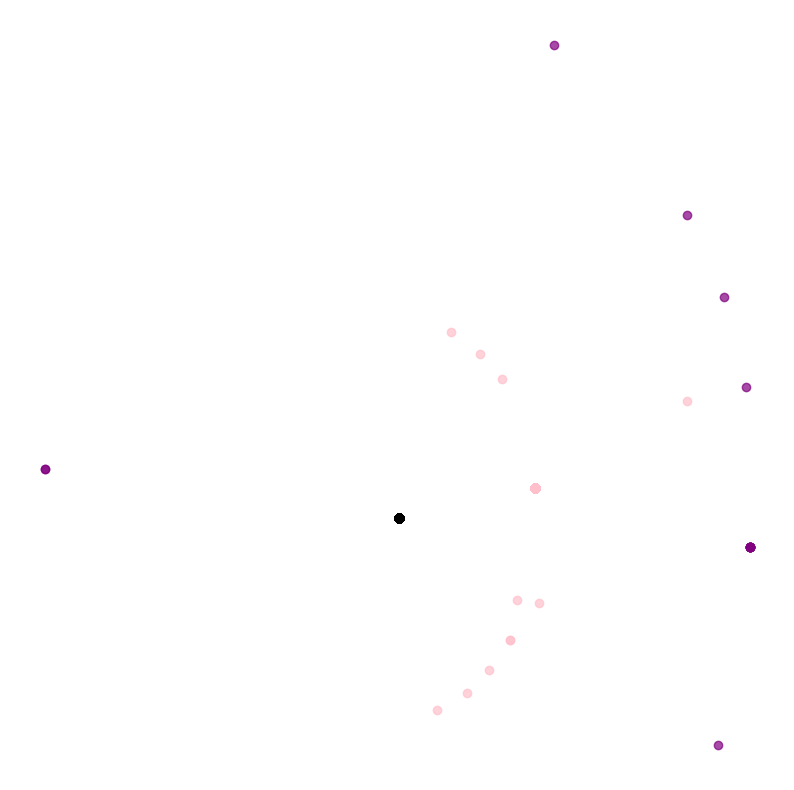

In [7]:

'''

During the forward pass, whenever the model processes an image, 
the registered hook captures the output of that layer.
for example - 
layer.register_forward_hook(hook_fn)

When you register a hook, PyTorch returns a handle 
(handle = layer.register_forward_hook(hook_fn)). 
This handle is an object that keeps track of the registered hook.
If you don't remove the hook, it persists in the model, and future
forward passes will keep executing the hook, possibly 
causing memory issues or unintended behavior.

'''

np.random.seed(100)

def get_intermediate_outputs(model, image_paths, layer_names):
    """Extracts outputs from specified layers of a frozen PyTorch model."""
    
    model.eval()
    intermediate_outputs = {name: [] for name in layer_names}
    device = next(model.parameters()).device  # Get model device

    
    def hook_fn(module, input, output, layer_name):
        # check and do average pooling of intermediate layers 
        if output.dim()>2: # this is an intermediate layer
            # remove the extra token i.e., the cls token - 
            output = output[:, 1:, :]
            # average mean of the patch dims -
            output = output.mean(dim=1) # you can also try max pooling here!
            
        intermediate_outputs[layer_name].append(output.detach().cpu())

    handles = []
    for name in layer_names:
        try:
            layer = model
            for part in name.split('.'):
                layer = getattr(layer, part) # basically we reach the layer that we want the ouput from!
            handle = layer.register_forward_hook(lambda module, input, output, layer_name=name: hook_fn(module, input, output, layer_name))
            handles.append(handle)
        except AttributeError:
            print(f"Layer '{name}' not found in the model.")
            return {}
    
    transform = T.Compose([
        T.Resize((64,64)),
        T.ToTensor(),
    ])


    image_labels = []
    with torch.no_grad():
        for image_path in image_paths:
            img = Image.open(image_path)
            img_tensor = transform(img).unsqueeze(0).to(device)
            model(img_tensor)  # Hooks capture outputs here

            # Extract the parent directory as the label
            label = os.path.basename(os.path.dirname(image_path))
            image_labels.append(label)

    # Remove hooks after processing all images
    for handle in handles:
        handle.remove()

    return intermediate_outputs, image_labels


##############################################################################

# Load model 
ckpt = "/data/lpandey/LOGS/VIT_Time/NeurIPS2025_RW_Rebuttal/temporallyScrambedlwithScheduler/vit6h/version_0/checkpoints/epoch=99-step=118799.ckpt"
model_type = "vit"
model = init_model(model=model_type, model_path=ckpt, heads=3, patch_size=8, image_size=64)

print("[INFO] Model successfully loaded.")

########################################################################################

# store all the test images in a list and select layers -  
image_paths = []
root_dir = "/data/lpandey/KittenAI_Dataset/LinearProbeTrainTest/test"
for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        image_paths.append(file_path)

print("[INFO] All {} image paths loaded successfully!".format(len(image_paths)))

# print("[INFO] Model Layers -- ")
# for name, module in model.named_modules():
#     print(name)

# enter layer names from which you want the outputs from here -
layer_names = ["model.model.transformer.layers.1.1"] # model.model.mlp_head, model.model.transformer.layers.0.1, model.model.transformer.layers.1.1, model.model.transformer.layers.2.1

if not layer_names:
    raise ValueError("No layer names provided. Please specify the layers to extract.")

print("[INFO] Layers selected -- \n", layer_names)

########################################################################################

# Call function - 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device) 
model.eval()


intermediate_outputs, image_labels = get_intermediate_outputs(model, image_paths, layer_names)

# if intermediate_outputs:
#     for layer_name, outputs in intermediate_outputs.items():
#         print(f"Outputs from layer '{layer_name}':")
#         for output in outputs:
#             print(output.shape)
# else:
#     print("Failed to get intermediate outputs.")

# print(image_labels)

#########################################################################################

# plot tSNE - 
# Flatten all feature vectors for t-SNE
layer_name = layer_names[0]  # Assuming only one layer is used
features = np.vstack(intermediate_outputs[layer_name])  # Convert to (num_samples, feature_dim) , ex - [2000, 512]


# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)  # Shape (num_samples, 2)

# Assign unique colors to each directory

unique_labels = sorted(list(set(image_labels))) # [0,10,20,...,90]

#label_to_color = {label: plt.cm.jet(i / len(unique_labels)) for i, label in enumerate(unique_labels)}

label_to_color = {
    '0': cmap_self8(0),
    '10': cmap_self(1),
    '20': cmap_self7(2),
    '30': cmap_self9(3),
    '40': cmap_self4(4),
    '50': cmap_self2(5),
    '60': cmap_self12(6),
    '70': cmap_self11(7),
    '80': cmap_self10(8),
    '90': cmap_self3(9),
}

colors = [label_to_color[label] for label in image_labels]




# Plot the t-SNE results
# plt.figure(figsize=(10, 7))
for i, label in enumerate(unique_labels):
    indices = [j for j, lbl in enumerate(image_labels) if lbl == label]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=label_to_color[label], label=label, alpha=0.7)

# plt.legend()
# plt.title("t-SNE Visualization of Extracted Features")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
plt.axis("off")
plt.show()

